In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 
    'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 
    'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)



In [3]:
bx = bmtf_gmt.bx
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel
stubsPhiB = bmtf_gmt.stubHwPhiB
stubsHwQual = bmtf_gmt.stubHwQual

In [4]:
Features = [nStubs, stubsStation, stubsSector, stubsWheel, stubsPhiB, stubsHwQual]

In [5]:
#Controlla che la stub successiva si trovi nella stazione dopo
def CheckStation(Station, StationP1, Direction):

   Diff = StationP1 - Station
   Index = ak.where(Diff == Direction)[0]

   return Index

#Controlla che la Wheel successiva sia +- 1 della wheel corrente, tranne per le wheel estremali
def CheckWheel(Wheel, WheelP1):
   
   IndexList = []

   if (Wheel == -2):
      Index = list(ak.where((WheelP1 == -1) | (WheelP1 == -2))[0])
      IndexList.extend(Index)

   elif (Wheel == 2):
      Index = list(ak.where((WheelP1 == 1) | (WheelP1 == 2))[0])
      IndexList.extend(Index)

   else:
      Diff = Wheel - WheelP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)

#Controlla che il settore successivo sia adiacente al settore corrente. Applica operazione ciclica per settori 11 e 0
def CheckSector(Sector, SectorP1):
   
   IndexList = []

   if (Sector == 11):
      Index = list(ak.where((SectorP1 == 10) | (SectorP1 == 11) | (SectorP1 == 0))[0])
      IndexList.extend(Index)

   elif (Sector == 0):
      Index = list(ak.where((SectorP1 == 11) | (SectorP1 == 0)| (SectorP1 == 1))[0])
      IndexList.extend(Index)

   else:
      Diff = Sector - SectorP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)

In [6]:
def SearchHSCP_StationLevel(Features, bx, Number, Direction):

   #If direction == 1 looks forward, if == -1 looks backward
   
   Property = []

   #Feature: 0 == Stubs, 1 == Station, 2 == Sector, 3 == Wheel, 4 == PhiB, 5 == Quality

   for i in tqdm.tqdm(range(Number - 1)):

      BoolChkStation = []      

      Dic = {}
      DicP1 = {}

      #Inizializzo dizionari
      for feature in ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']:
         Dic[feature] = []
         DicP1[feature] = []

      
      if ((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[1][i+1] != Features[1][i] + Direction):
         continue

      elif (Direction == -1 and (Features[0][i] == 1 and Features[0][i+1] == 1) and Features[1][i] == 1):
         continue
      
      #Caso in cui ci sia solo 1 elemento nell'iesimo BX e 1 elemento nel BX successivo
      elif ((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[1][i+1] == Features[1][i] + Direction and Features[1][i] != 4):
         nStubs = [Features[0][i], Features[0][i+1]]    

         Dic['Station'].extend(Features[1][i])
         Dic['Sector'].extend(Features[2][i])
         Dic['Wheel'].extend(Features[3][i])
         Dic['PhiB'].extend(Features[4][i])
         Dic['Quality'].extend(Features[5][i])

         DicP1['Station'].extend(Features[1][i+1])
         DicP1['Sector'].extend(Features[2][i+1])
         DicP1['Wheel'].extend(Features[3][i+1])
         DicP1['PhiB'].extend(Features[4][i+1])
         DicP1['Quality'].extend(Features[5][i+1])

      
      #Controllo duplicati viene fatto più avanti per ridurre i missmatch

      elif (Features[0][i] > Features[0][i+1]):
         for j in range(Features[0][i]):
            ChkStation = CheckStation(Features[1][i][j], Features[1][i+1], Direction)
            
            if (len(ChkStation) != 0):
               nStubs = [Features[0][i], Features[0][i+1]]
               
               keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
               for idx, key in enumerate(keys, start=1):
                  Dic[key].append(Features[idx][i][j])
                  
               # Assegnazioni per l'elemento successivo (P1)
               for idx, key in enumerate(keys, start=1):
                  DicP1[key].extend([Features[idx][i+1][k] for k in ChkStation])


      else:
         #Tutti gli altri casi
         for j in range(Features[0][i]):
            ChkStation = CheckStation(Features[1][i][j], Features[1][i+1], Direction)
            nStubs = [Features[0][i], Features[0][i+1]]

            if (len(ChkStation) == 0):
               BoolChkStation.append(False)
            else:
               BoolChkStation.append(True)

         if (np.any(np.array(BoolChkStation))):
            keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']
            for idx, key in enumerate(keys, start=1):
               Dic[key].append(Features[idx][i][j])
               
            for idx, key in enumerate(keys, start=1):
               DicP1[key].extend([Features[idx][i+1][k] for k in ChkStation])

      if (len(Dic['Station']) != 0):

         Dictionary = {
            'i': i,
            'bx': bx[i],
            'nStubs': nStubs,
            'property': Dic,
            'propertyP1': DicP1
         }


         Property.append(Dictionary)


   return ak.Array(Property)
   

In [7]:
# StationFilteredForward = SearchHSCP_StationLevel(Features, bx, 1_000_000, 1) # len(Features[0])

# with open('StationFilteredForward.pkl', 'wb') as f:
#    pickle.dump(StationFilteredForward, f)

# with open('StationFilteredForword.pkl', 'rb') as f:
#     StationFilteredForword = pickle.load(f)

In [8]:
with open('StationFiltered.pkl', 'rb') as f:
    StationFiltered = pickle.load(f)

In [9]:
# StationFilteredBackward = SearchHSCP_StationLevel(Features, bx, 1_000_000, -1)

# with open('StationFilteredBackward.pkl', 'wb') as f:
#    pickle.dump(StationFilteredBackward, f)

# with open('StationFilteredBackward.pkl', 'rb') as f:
#     StationFilteredBackward = pickle.load(f)

In [33]:
StationFiltered

<Array [{i: 5, nStubs: [...], ...}, ..., {...}] type='3918148 * {i: int64, ...'>

In [11]:
#Creare una maschera che nasconda gli elementi che non sono conformi alla ricerca di HSCP o Muoni cosmici
def CosmicMuons(StationFiltered):

   Mask = []

   for i in tqdm.tqdm(range(len(StationFiltered))):

      Sector, SectorP1 = StationFiltered[i]['property'].Sector, StationFiltered[i]['propertyP1'].Sector
      Wheel, WheelP1 = StationFiltered[i]['property'].Wheel, StationFiltered[i]['propertyP1'].Wheel

      property = StationFiltered[i]['property']
      propertyP1 = StationFiltered[i]['propertyP1']
      
      if (len(property.Station) == 1 and len(propertyP1.Station) >= 1):

         IndexSector = CheckSector(Sector, SectorP1)
         IndexWheel = CheckWheel(Wheel, WheelP1)
        
         if (len(IndexSector) != 0 and len(IndexWheel) != 0):
            Mask.append(i)

      else:
         for j in range(len(property.Station)):
            IndexSector = CheckSector(Sector[j], SectorP1)
            IndexWheel = CheckWheel(Wheel[j], WheelP1)

            if (len(IndexSector) != 0 and len(IndexWheel) != 0):
               Mask.append(i)

         
   return StationFiltered[Mask]

In [12]:
# CosmicMuonsPropertyForward = CosmicMuons(StationFilteredForward)

# with open('CosmicMuonsPropertyForward.pkl', 'wb') as f:
#    pickle.dump(CosmicMuonsPropertyForward, f)

# with open('CosmicMuonsPropertyForward.pkl', 'rb') as f:
#     CosmicMuonsPropertyForward = pickle.load(f)

In [13]:
# CosmicMuonsPropertyBackward = CosmicMuons(StationFilteredBackward)

# with open('CosmicMuonsPropertyBackward.pkl', 'wb') as f:
#    pickle.dump(CosmicMuonsPropertyBackward, f)

# with open('CosmicMuonsPropertyBackward.pkl', 'rb') as f:
#     CosmicMuonsPropertyBackward = pickle.load(f)

In [14]:
# with open('CosmicMuonsProperty.pkl', 'wb') as f:
#    pickle.dump(CosmicMuonsProperty, f)

with open('CosmicMuonsProperty.pkl', 'rb') as f:
    CosmicMuonsProperty = pickle.load(f)

In [34]:
CosmicMuonsProperty

<Array [{i: 25, nStubs: [...], ...}, ...] type='868215 * {i: int64, nStubs:...'>

In [16]:
def PhiCosmicMuons(CosmicMuonsProperty, bx, Sector):
   Neg, Pos = [], []

   for i in tqdm.tqdm(range(len(CosmicMuonsProperty))):
      Dic, DicP1 = {}, {}

      for feature in ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality']:
         Dic[feature] = []
         DicP1[feature] = []

      for j in range(len(CosmicMuonsProperty[i]['property'].Station)):

         IndexSector = CheckSector(CosmicMuonsProperty[i]['property'].Sector[j], CosmicMuonsProperty[i]['propertyP1'].Sector)
         IndexWheel = CheckWheel(CosmicMuonsProperty[i]['property'].Wheel[j], CosmicMuonsProperty[i]['propertyP1'].Wheel)

         if len(IndexSector) > 0:
            IndexSector = IndexSector[0]
         else:
            IndexSector = None

         if len(IndexWheel) > 0:
            IndexWheel = IndexWheel[0]
         else:
            IndexWheel = None

         if IndexSector is not None and IndexWheel is not None:
            Dic['Station'].append(CosmicMuonsProperty[i]['property'].Station[j])
            DicP1['Station'].append(CosmicMuonsProperty[i]['propertyP1'].Station[j])

            Dic['Sector'].append(CosmicMuonsProperty[i]['property'].Sector[j])
            DicP1['Sector'].append(CosmicMuonsProperty[i]['propertyP1'].Sector[IndexSector])

            Dic['Wheel'].append(CosmicMuonsProperty[i]['property'].Wheel[j])
            DicP1['Wheel'].append(CosmicMuonsProperty[i]['propertyP1'].Wheel[IndexWheel])

            Dic['PhiB'].append(CosmicMuonsProperty[i]['property'].PhiB[j])
            DicP1['PhiB'].append(CosmicMuonsProperty[i]['propertyP1'].PhiB[j])

            Dic['Quality'].append(CosmicMuonsProperty[i]['property'].Quality[j])
            DicP1['Quality'].append(CosmicMuonsProperty[i]['propertyP1'].Quality[j])

            if (CosmicMuonsProperty[i]['property'].Sector[j] in Sector):
               NegativeDictionary = {
                  'i': CosmicMuonsProperty[i]['i'],
                  'bx': bx[CosmicMuonsProperty[i]['i']],
                  'property': Dic,
                  'propertyP1': DicP1
               }
               Neg.append(NegativeDictionary)


   return ak.Array(Neg)

In [17]:
# Foreward = PhiCosmicMuons(CosmicMuonsPropertyForeward, bx, [0, 11, 10, 9, 8, 7])

# # with open('Foreward.pkl', 'wb') as f:
# #    pickle.dump(Foreward, f)

# with open('Foreward.pkl', 'rb') as f:
#    Foreward = pickle.load(f)

In [18]:
# Backward = PhiCosmicMuons(CosmicMuonsPropertyBackward, bx, [1, 2, 3, 4, 5, 6])

# # with open('Backward.pkl', 'wb') as f:
# #    pickle.dump(Backward, f)

# with open('Backward.pkl', 'rb') as f:
#    Backward = pickle.load(f)

In [19]:
# with open('Neg.pkl', 'wb') as f:
#    pickle.dump(Neg, f)

# with open('Pos.pkl', 'wb') as f:
#    pickle.dump(Pos, f)

with open('Neg.pkl', 'rb') as f:
    Neg = pickle.load(f)

with open('Pos.pkl', 'rb') as f:
   Pos = pickle.load(f)

In [20]:
Neg

<Array [{i: 25, bx: 489, ...}, ..., {...}] type='535941 * {i: int64, bx: in...'>

In [21]:
BunchCrossing = bx[CosmicMuonsProperty['i']]
BunchCrossingNeg = bx[Neg['i']]
BunchCrossingPos = bx[Pos['i']]

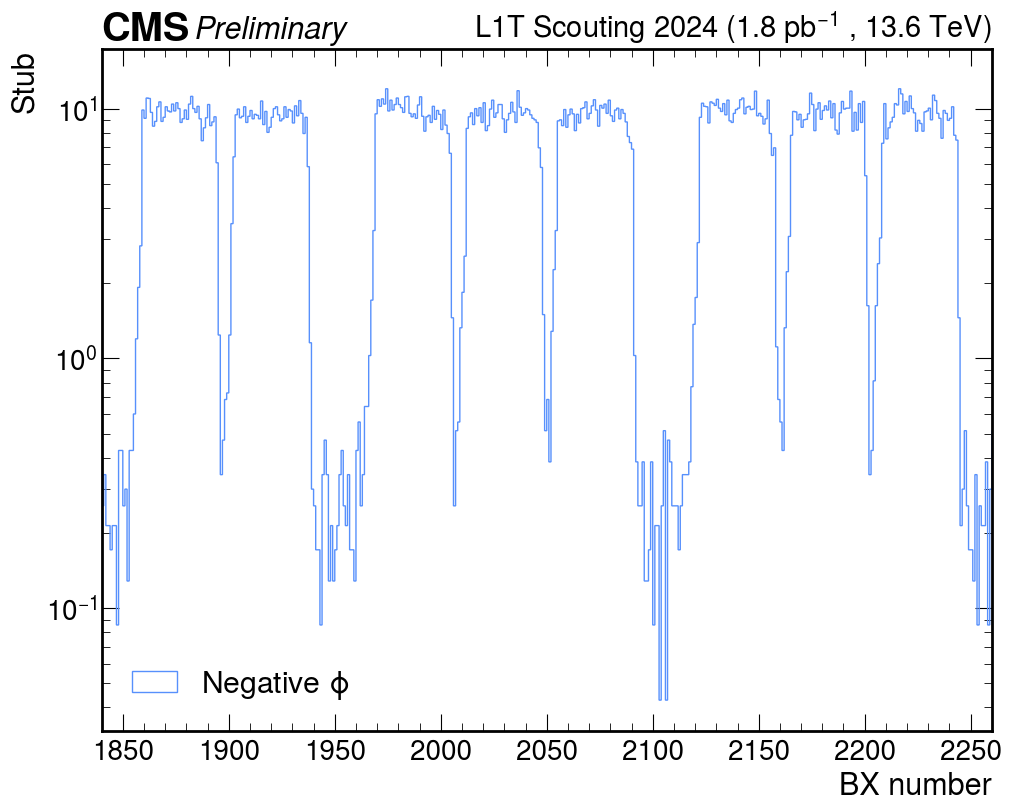

In [35]:
bx_range = np.arange(ONE_ORBIT_IN_BX + 2)

BinCountNeg = np.bincount(BunchCrossingNeg)
BinCountPos = np.bincount(BunchCrossingPos)

fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_cms_label(ax, fontsize= FONTSIZE)

#ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BinCountPos), histtype='step', label=r'Positive $\phi$')
ax.hist(bx_range[:-1], bins=bx_range, weights=ConvertToHz(BinCountNeg), histtype='step', label=r'Negative $\phi$')

ax.set_xlabel('BX number')
ax.set_ylabel('Stub')
ax.set_xlim(0, ONE_ORBIT_IN_BX)
#ax.set_ylim(0.1, 15)
ax.set_xlim(1840, 2260)
ax.legend()

ax.set_yscale('log')

In [23]:
nBmtf = bmtf_gmt.nBmtfMuons
BmtfPt = bmtf_gmt.bmtfPt
BmtfPhi = bmtf_gmt.bmtfPhi
BmtfEta = bmtf_gmt.bmtfEta
BmtfSign = bmtf_gmt.bmtfHwSign
BmtfSignValid = bmtf_gmt.bmtfHwSignValid


FeaturesBMTF = [nBmtf, BmtfPt, BmtfPhi, BmtfEta, BmtfSign, BmtfSignValid]

In [24]:
def MatchBMTF(Stubs, bx, Features):

   #Feature: 0 == nBmtf, 1 == Pt, 2 == Phi, 3 == Eta, 4 == Sign, 5 == SignValid

   BMTFArray = []

   for i in tqdm.tqdm(range(len(Stubs))):

      Dic = {}
      DicP1 = {}

      for feature in ['nBmtf', 'Pt', 'Phi', 'Eta', 'Sign', 'SignValid']:
         Dic[feature] = []
         DicP1[feature] = []

      if Features[0][Stubs[i]['i']] > 0 and Features[0][Stubs[i]['i'] + 1] > 0:
         keys = ['nBmtf', 'Pt', 'Phi', 'Eta', 'Sign', 'SignValid']
         for idx, key in enumerate(keys):
            Dic[key].append(Features[idx][Stubs[i]['i']])
            DicP1[key].append(Features[idx][Stubs[i]['i'] + 1])

      
         Dictionary = {
            'i': Stubs[i]['i'],
            'bx': bx[Stubs[i]['i']],
            'property': Dic,
            'propertyP1': DicP1,
            'Stubs': Stubs[i]
         }


         BMTFArray.append(Dictionary)

   return ak.Array(BMTFArray)

In [25]:
# NegBMTFMatch = MatchBMTF(Neg, bx, FeaturesBMTF)
# PosBMTFMatch = MatchBMTF(Pos, bx, FeaturesBMTF)

In [26]:
# with open('NegBMTFMatch.pkl', 'wb') as f:
#    pickle.dump(NegBMTFMatch, f)

# with open('PosBMTFMatch.pkl', 'wb') as f:
#    pickle.dump(PosBMTFMatch, f)


with open('NegBMTFMatch.pkl', 'rb') as f:
    NegBMTFMatch = pickle.load(f)

with open('PosBMTFMatch.pkl', 'rb') as f:
   PosBMTFMatch = pickle.load(f)

In [27]:
NegBMTFMatch.property

<Array [{nBmtf: [1], Pt: [[6.5]], ...}, ...] type='49869 * {nBmtf: var * in...'>

In [28]:
np.min(ak.ravel(PosBMTFMatch['propertyP1'].SignValid))

1

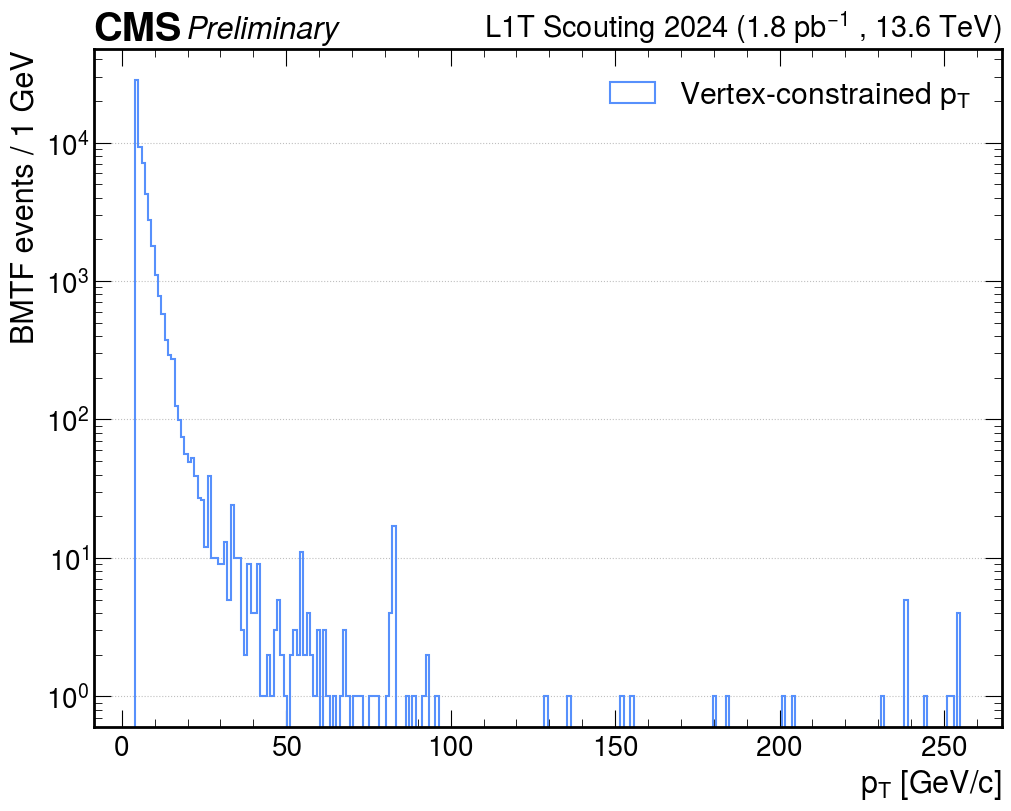

In [29]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_cms_label(ax, fontsize= FONTSIZE)

ax.hist(ak.ravel(NegBMTFMatch['property'].Pt), bins = 250, label='Vertex-constrained $p_T$', histtype='step', linewidth = 1.5)

ax.set_xlabel(r'$p_T$ [GeV/c]')
ax.set_ylabel(r'BMTF events / 1 GeV')
ax.set_axisbelow(True)

ax.legend()

ax.grid(visible=True, axis='y')
ax.set_yscale('log')

#plt.savefig("../Immagini/BMTF_PtPtu.pdf")

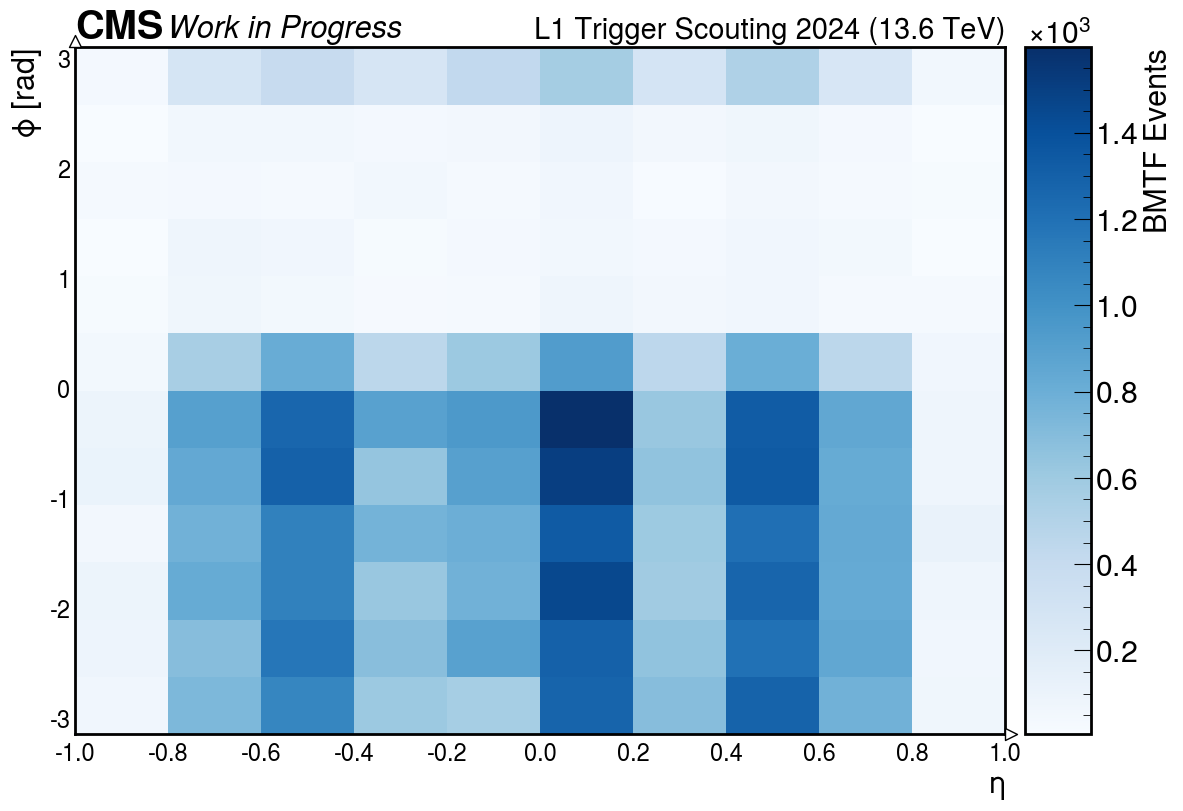

In [30]:
binsPhi = np.array(np.arange(-np.pi, np.pi + 0.1, 0.52))
binsEta = np.array(np.arange(-1, 1.1, 0.2))


hist2d = hist.Hist(
    hist.axis.Variable(binsEta, name='Eta', label="Eta"),
    hist.axis.Variable(binsPhi, name='Phi', label="Phi"),
)
hist2d.fill(Phi=ak.ravel(NegBMTFMatch['property'].Phi), Eta=ak.ravel(NegBMTFMatch['property'].Eta))

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

from matplotlib.colors import LogNorm


hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,)

cbar = ax.collections[0].colorbar
cbar.set_label('BMTF Events', fontsize=FONTSIZE)

#Notazione scientifica
cbar.formatter = ticker.ScalarFormatter(useMathText=True)
cbar.formatter.set_scientific(True)  
cbar.formatter.set_powerlimits((-2, 2))  
cbar.update_ticks() 

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\phi$ [rad]')

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

# plt.savefig("../Immagini/BMTFPhiEta.pdf")
# plt.savefig("../Immagini/ImmaginiPNG/BMTFPhiEta.png")

plt.show()
